## Setup and Imports

In [1]:
import os
os.chdir('/Users/kadofong/work/projects/merian/pieridae/merger_analysis/notebooks')

In [2]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# Add pieridae to path
sys.path.insert(0, str(Path.cwd().parents[1]))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import pickle
from tqdm import tqdm

from pieridae.starbursts.byol import (
    BYOLModelManager,
    EmbeddingAnalyzer,
    LabelPropagation,
    load_merian_images
)

# Plotting utilities
from ekfplot import plot as ek, colors as ec
from matplotlib import colors

print("✅ Imports complete")

/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


✅ Imports complete


In [3]:
import pandas as pd
from astropy import table
from ekfparse import query
from pieridae.starbursts import sample

## Load Configuration

In [433]:
# Load config
config_path = '../configs/galaxyzoo.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

config['data']['input_path'] = Path(config['data']['input_path'])
config['data']['output_path'] = Path(config['data']['output_path'])

print(f"📋 Configuration loaded")
print(f"   Input: {config['data']['input_path']}")
print(f"   Output: {config['data']['output_path']}")

📋 Configuration loaded
   Input: ../../local_data/pieridae_output/starlet/massive_galaxies
   Output: ../output/galaxy_zoo


## Load Data and Embeddings

In [421]:
def load_image_by_name(img_name: str, data_path: Path) -> np.ndarray:
    """
    Load a single galaxy image on-demand.
    
    Parameters
    ----------
    img_name : str
        Galaxy ID (e.g., 'M1234567890123456789')
    data_path : Path
        Base data directory path
    
    Returns
    -------
    image : np.ndarray
        Image array with shape (3, H, W) containing [g-band, i-band, hf_i-band]
    """
    i_file = data_path / img_name / f"{img_name}_i_results.pkl"
    g_file = data_path / img_name / f"{img_name}_g_results.pkl"
    
    img = []
    for band_file in [g_file, i_file]:
        with open(band_file, 'rb') as f:
            xf = pickle.load(f)
            img.append(xf['image'])
            if band_file == i_file:
                img.append(xf['hf_image'])  # Add HF image for i-band
    
    return np.array(img, dtype=np.float32)

print("✅ Image loading helper function defined")

✅ Image loading helper function defined


In [422]:
# Don't load all images upfront - will load dynamically as needed for plots
print("⏭️ Skipping full image load (will load dynamically for plots)")
print("   This saves memory and startup time")

# Get image names and data path for dynamic loading
from pieridae.starbursts.byol import load_merian_images
data_path = config['data']['input_path']

# Just get the image names without loading actual images
import glob
pattern = f"{data_path}/M*/*i_results.pkl"
filenames = glob.glob(pattern)

# Validate files exist
valid_files = []
for fname in filenames:
    g_file = fname.replace('_i_', '_g_')
    i_file = fname
    if os.path.exists(g_file) and os.path.exists(i_file):
        valid_files.append(fname)

img_names = np.array([Path(fname).parent.name for fname in valid_files])
print(f"✅ Found {len(img_names)} images (not loaded into memory)")
print(f"   Data path: {data_path}")

⏭️ Skipping full image load (will load dynamically for plots)
   This saves memory and startup time
✅ Found 3883 images (not loaded into memory)
   Data path: ../../local_data/pieridae_output/starlet/massive_galaxies


In [434]:
# Load or extract embeddings
output_path = config['data']['output_path']
embeddings_file = output_path / 'embeddings.npy'

if embeddings_file.exists():
    print("Loading existing embeddings...")
    embeddings = np.load(embeddings_file)
else:
    print("Extracting embeddings from trained model...")
    model_manager = BYOLModelManager(config, output_path)
    embeddings = model_manager.extract_embeddings(images)

print(f"✅ Embeddings shape: {embeddings.shape}")

Loading existing embeddings...
✅ Embeddings shape: (3883, 512)


In [425]:
full_catalog, masks = sample.load_sample(
    '/Users/kadofong/work/projects/merian/local_data/base_catalogs/mdr1_n708maglt26_and_pzgteq0p1.parquet'
)
base_catalog = full_catalog.loc[masks['is_good'][0]]

datadir = '../../local_data/pieridae_output/starlet/msorabove_v0/'
for sid in tqdm(base_catalog.index):
    filename = f'{datadir}/{sid}/{sid}_i_results.pkl'
    if not os.path.exists(filename):
        continue
    with open(filename, 'rb') as f:
        x = pickle.load(f)
    base_catalog.loc[sid, 'logmass_adjusted'] = x['logmass_adjusted']
base_catalog.loc[base_catalog['logmass_adjusted'].isna(),'logmass_adjusted'] = base_catalog.loc[base_catalog['logmass'].isna(),'logmass_adjusted']

dm = base_catalog['logmass_adjusted'] - base_catalog['logmass']
catalog = base_catalog.loc[dm < 0.5]

/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/work/projects/merian/carpenter/src/carpenter/emission.py:338: RuntimeWarning: divide by zero encountered in reciprocal
  emission_correction = correct_NIISII(redshift_values, aperture_corrected_logmass)**-1


Computed aperture correction in 0.0 seconds.
Computed line contamination correction in 0.0 seconds.
Loading precomputed Galactic extinction map...
Interpolated Galactic extinction values from map.
Computed Galactic extinction correction in 0.5 seconds.


/Users/kadofong/work/projects/merian/agrias/python/agrias/photometry.py:115: RuntimeWarning: invalid value encountered in log10
  lsq_y = np.log10(np.array([ fdict[band] for band in plawbands ]))
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Computed internal extinction corrections in 0.6 seconds.


  0%|                                                 | 0/54859 [00:00<?, ?it/s]/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_76991/3428961236.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_catalog.loc[sid, 'logmass_adjusted'] = x['logmass_adjusted']
100%|███████████████████████████████████| 54859/54859 [00:19<00:00, 2878.65it/s]


In [426]:
catalog = base_catalog.reindex(img_names)
dm = catalog['logmass_adjusted'] - catalog['logmass']
catalog = catalog.loc[(dm < 0.5)&(catalog['logmass_adjusted']<=10.5)&(catalog['logmass_adjusted']>=7.5)]

In [30]:
gz = table.Table.read(
    '../local_data/galaxy_zoo_classifications/dr5/gzdv5.dat',
    readme='../local_data/galaxy_zoo_classifications/dr5/ReadMe',
    format='cds'
)

gz_df = gz.to_pandas ()


mmatch, gzmatch = query.match_catalogs(catalog, gz_df, coordkeysB=['RAdeg','DEdeg'])
gzmatch = gzmatch.reset_index().set_index(mmatch.index)

## Dimensionality Reduction

In [435]:
# Compute PCA
print("Computing PCA...")
analyzer = EmbeddingAnalyzer(config)
embeddings_pca = analyzer.compute_pca(embeddings)

explained_var = analyzer.pca.explained_variance_ratio_.sum() * 100
print(f"✅ PCA complete: {analyzer.pca.n_components_} components")
print(f"   Explained variance: {explained_var:.1f}%")

2025-10-29 22:23:42,290 - INFO - Computing PCA...
2025-10-29 22:23:42,358 - INFO - PCA components: 10
2025-10-29 22:23:42,358 - INFO - Explained variance: 86.6%


Computing PCA...
✅ PCA complete: 10 components
   Explained variance: 86.6%


## Load Classification Labels

In [606]:
# Load labels
label_file = Path(config.get('labels', {}).get('classifications_file', ''))
#
if label_file.exists():
    mergers = pd.read_csv(label_file, index_col=0)
    labels = mergers.reindex(img_names)
    labels = labels.replace(np.nan, 0).values.flatten().astype(int)
    
    print(f"✅ Loaded {len(labels)} labels")
    
    # Print distribution
    label_meanings = config.get('labels', {}).get('label_mapping', {})
    unique, counts = np.unique(labels, return_counts=True)
    
    print("\n📊 Label distribution:")
    for label_val, count in zip(unique, counts):
        meaning = label_meanings.get(label_val, f"unknown_{label_val}")
        print(f"   {label_val} ({meaning}): {count} objects")
else:
    print(f"⚠️  Label file not found: {label_file}")
    labels = np.zeros(len(img_names), dtype=int)

✅ Loaded 3883 labels

📊 Label distribution:
   0 (unclassified): 3563 objects
   1 (not_eod): 264 objects
   2 (edgeon): 56 objects


In [607]:
test_labels = pd.read_csv(
    Path('../../../quick_projects/vizinspect_eod/scripts/eodclassifications_kadofong_current.csv'),
    index_col = 0
).reindex(img_names).replace(np.nan,0).values.flatten().astype(int)

# Print distribution
label_meanings = config.get('labels', {}).get('label_mapping', {})
unique, counts = np.unique(labels, return_counts=True)

print("\n📊 Label distribution:")
for label_val, count in zip(unique, counts):
    meaning = label_meanings.get(label_val, f"unknown_{label_val}")
    print(f"   {label_val} ({meaning}): {count} objects")

test_labels = labels


📊 Label distribution:
   0 (unclassified): 3563 objects
   1 (not_eod): 264 objects
   2 (edgeon): 56 objects


## K-NN Label Propagation

In [608]:
# Initialize label propagation
n_neighbors = config.get('labels', {}).get('n_neighbors', 15)
n_min = config.get('labels', {}).get('minimum_labeled_neighbors', 5)
n_min_auto = config.get('labels', {}).get('minimum_labeled_neighbors_for_autoprop', 15)
print(f"Using minimum_labeled_neighbors_for_autoprop = {n_min_auto}")
print(f"Using {n_neighbors} neighbors for weighted voting")
print(f"Using minimum_labeled_neighbors = {n_min}")

propagator = LabelPropagation(
    n_neighbors=n_neighbors,
    n_min=n_min,
    n_min_auto=n_min_auto,
    prob_threshold=config.get('labels', {}).get('prob_threshold', 0.9),
    frag_threshold=config.get('labels', {}).get('frag_threshold', 0.25),
)

# Run iterative propagation
print("\nRunning iterative label propagation...")
iterative_labels, n_labels_iter, prob_labels_iter, stats = \
    propagator.iterative_propagation(embeddings_pca, labels, handle_fragmentation_separately=False)

print(f"\n✅ Label propagation complete")
print(f"   Human labels: {stats['n_human']}")
print(f"   Auto-labels added: {stats['n_added_iteration']}")
print(f"   Total labels: {stats['n_final_auto']}")

2025-10-29 23:07:13,946 - INFO - 
Starting iterative label estimation...
2025-10-29 23:07:13,947 - INFO - Finding 50 nearest neighbors...
2025-10-29 23:07:14,077 - INFO - Human labels: 320
/Users/kadofong/work/projects/merian/pieridae/pieridae/starbursts/byol.py:705: RuntimeWarning: invalid value encountered in divide
  weights /= np.nansum(weights, axis=1).reshape(-1, 1)
2025-10-29 23:07:14,080 - INFO - 1034 objects have auto-labels
2025-10-29 23:07:14,081 - INFO - 2849 objects have fewer than 5 labeled neighbors
2025-10-29 23:07:14,081 - INFO - Initial auto-labels: 1034 objects have potential probabilistic labels
2025-10-29 23:07:14,082 - INFO - Added 379 auto-labels in first iteration
2025-10-29 23:07:14,082 - INFO - Total labels after iteration: 699
2025-10-29 23:07:14,082 - INFO - 
Recalculating with expanded label set...
2025-10-29 23:07:14,086 - INFO - 3231 objects have auto-labels
2025-10-29 23:07:14,087 - INFO - 652 objects have fewer than 5 labeled neighbors
2025-10-29 23:07:

Using minimum_labeled_neighbors_for_autoprop = 10
Using 50 neighbors for weighted voting
Using minimum_labeled_neighbors = 5

Running iterative label propagation...

✅ Label propagation complete
   Human labels: 320
   Auto-labels added: 379
   Total labels: 3231


## Identify EOD Candidates

In [609]:
# Identify mergers based on probability labels
possible_eod =  prob_labels_iter[:, 2] > prob_labels_iter[:, 1]

is_eod = prob_labels_iter[:, 2] > 0.5
is_bulge = prob_labels_iter[:, 1] > 0.5

catalog['p_eod'] = prob_labels_iter[:,2]
catalog['p_not_eod'] = prob_labels_iter[:,1]



print(f"📊 Merger identification:")
print(f"   Possible EoD: {possible_eod.sum()}")

📊 Merger identification:
   Possible EoD: 71


## Visualizations

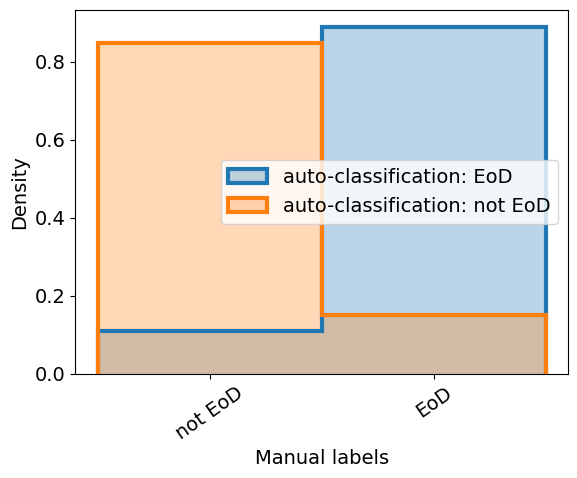

In [610]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

# Compare with manual labels
if (test_labels > 0).any():    
    # Create contingency table
    manual_eod = labels == 2
    manual_noneod = labels == 1  
    
    hist_kwargs = {'alpha': 0.3, 'lw': 3, 'bins': np.arange(0.5, 3.5), 'density': True}
    
    ek.hist(test_labels[is_eod], ax=ax, label='auto-classification: EoD', **hist_kwargs)
    ek.hist(test_labels[is_bulge], ax=ax, label='auto-classification: not EoD', **hist_kwargs)
    
    ax.set_xticks(np.arange(1,3),['not EoD', 'EoD'], rotation=35)
    ax.set_xlabel('Manual labels')
    ax.set_ylabel('Density')
    ax.legend()
    
    plt.tight_layout()


In [611]:
has_classification = gzmatch['NbDEO'] > 0
is_eod = (gzmatch['DEOyes'] > 0.8) & has_classification
is_bulge = (gzmatch['BSNo'] < 0.5) & has_classification
not_eod = (gzmatch['DEOyes'] < 0.2) & has_classification

df = pd.DataFrame(index=mmatch.index, columns=['classification'])
df.loc[:,'classification'] = 0
df.loc[is_eod.values, 'classification'] = 2
#df.loc[is_bulge.values, 'classification'] = 3
df.loc[not_eod.values, 'classification'] = 1
print(np.unique(df['classification'], return_counts=True))
df.to_csv('../local_data/galaxy_zoo_classifications/classifications.csv')

(array([0, 1, 2], dtype=object), array([243, 264,  56]))


3216


/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_76991/3980626376.py:9: RuntimeWarning: invalid value encountered in scalar divide
  purity = tp / (tp+fp)


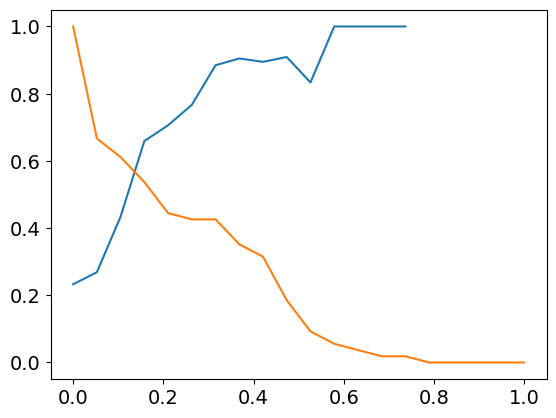

In [612]:
has_classification = (prob_labels_iter>0).any(axis=1)&(catalog['logmass_adjusted'].values>9.)#&(gzmatch.reindex(img_names)['NbDEO'].values > 10)
print(has_classification.sum())
def threshold ( p ):
    tp = ((prob_labels_iter[has_classification,2]>p) & (test_labels[has_classification]==2)).sum() #/ (test_labels[has_classification]==2).sum()
    fp = ((prob_labels_iter[has_classification,2]>p) & (test_labels[has_classification]==1)).sum() #/ (test_labels[has_classification]==1).sum()
    tn = ((prob_labels_iter[has_classification,2]<p) & (test_labels[has_classification]==1)).sum() #/ (test_labels[has_classification]==1).sum()
    fn = ((prob_labels_iter[has_classification,2]<p) & (test_labels[has_classification]==2)).sum() #/ (test_labels[has_classification]==2).sum()
    
    purity = tp / (tp+fp)
    recall = tp / (tp+fn)

    return purity, recall
    

ps = np.linspace(0.,1.,20)
metrics = np.array([ threshold(p) for p in ps ])

plt.plot(ps, metrics[:,0])
plt.plot(ps, metrics[:,1])

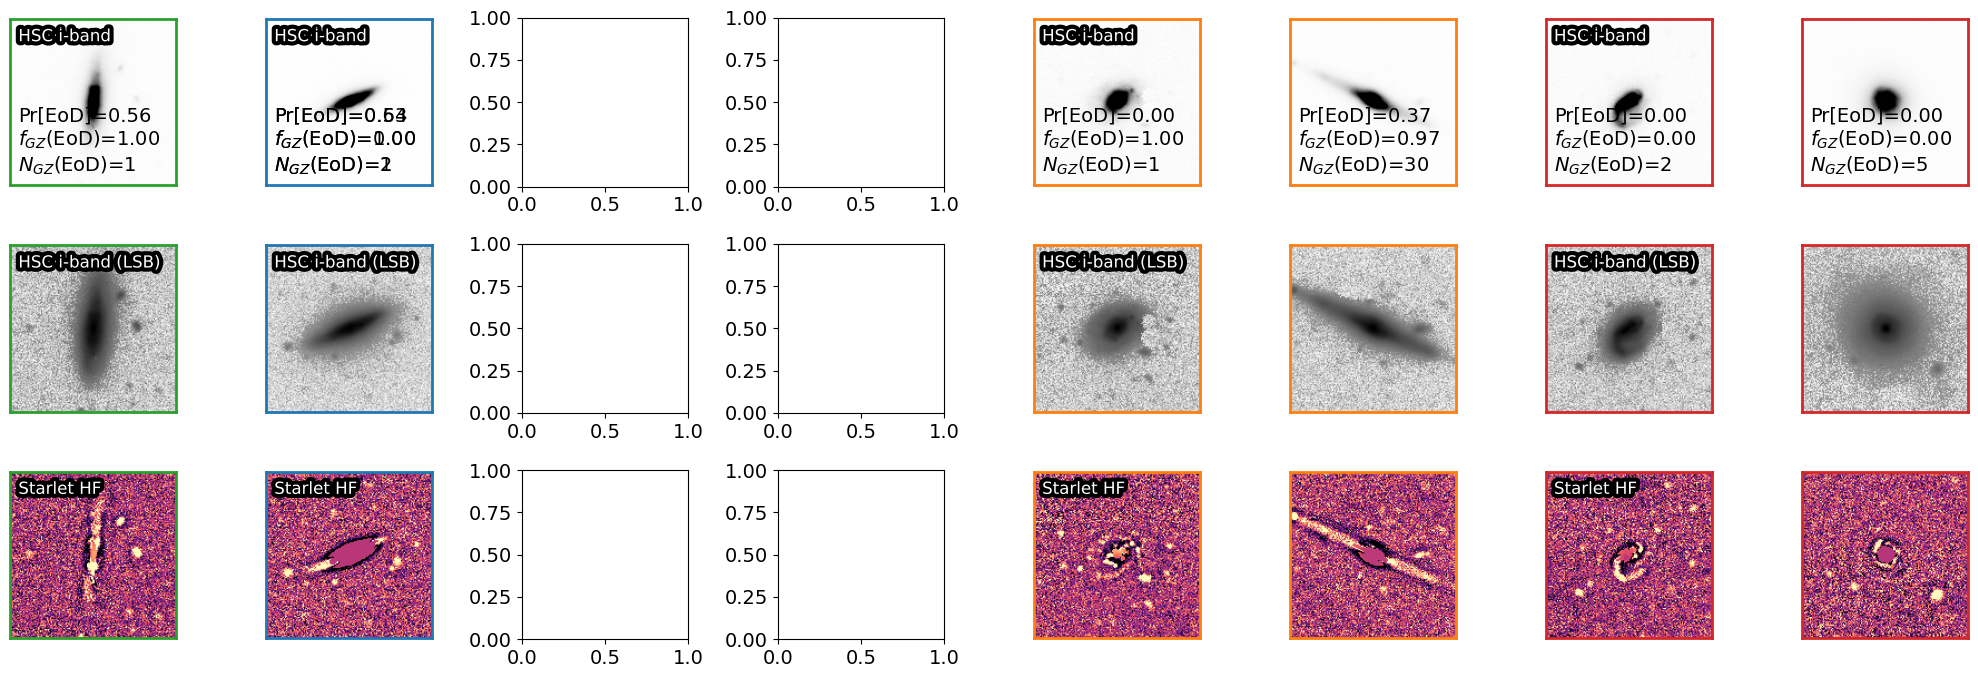

In [613]:
# Show examples of conflicts
candidates_l = [
    np.arange(len(img_names))[has_classification][ (prob_labels_iter[has_classification,2]>0.5) & (test_labels[has_classification]==2) ], # AyMy
    np.arange(len(img_names))[has_classification][ (prob_labels_iter[has_classification,2]>0.5) & (test_labels[has_classification]==1) ], # AyMn
    np.arange(len(img_names))[has_classification][ (prob_labels_iter[has_classification,1]>0.5) & (test_labels[has_classification]==2) ], # AnMy
    np.arange(len(img_names))[has_classification][ (prob_labels_iter[has_classification,1]>0.5) & (test_labels[has_classification]==1) ], # AnMn
]
clist = ['tab:green','tab:blue','tab:orange','tab:red']

n_examples=2
fig, f_axarr = plt.subplots(3, 4*n_examples, figsize=(n_examples*2.5*4, 7))

np.random.seed(11132)#52)
for cdx,candidates in enumerate(candidates_l):
    n_examples = min(2, len(candidates))
    if n_examples > 0:
        example_indices = np.random.choice(candidates, n_examples, replace=False)        

        axarr = f_axarr[:,cdx*n_examples:(cdx+1)*n_examples]
        
        for idx, gix in enumerate(example_indices):
            # Load this specific image on-demand
            img_name = img_names[gix]
            image = load_image_by_name(img_name, data_path)
            
            # i-band
            ek.imshow(image[1], ax=axarr[0, idx], q=0.01, cmap='Greys')
            
            # i-band log scale
            axarr[1, idx].imshow(
                image[1],
                origin='lower',
                cmap='Greys',
                norm=colors.SymLogNorm(linthresh=0.1)
            )
            
            # High-frequency
            ek.imshow(image[2], ax=axarr[2, idx], cmap='magma')
            if img_name in gzmatch.index:
                ek.text(0.05, 0.05,
                        rf'''Pr[EoD]={prob_labels_iter[gix, 2]:.2f}
$f_{{GZ}}$(EoD)={gzmatch.loc[img_name,'DEOyes']:.2f}
$N_{{GZ}}$(EoD)={gzmatch.loc[img_name,'NbDEO']:.0f}''',
                        ax=axarr[0,idx])
            else:
                ek.text(0.05, 0.05,
                        rf'''Pr[EoD]={prob_labels_iter[gix, 2]:.2f}''',
                        ax=axarr[0,idx])                
            
        
        for ax in axarr.flatten():
            ax.set_xticks([])
            ax.set_yticks([])
        
        ek.text(0.05, 0.95, 'HSC i-band', ax=axarr[0, 0], fontsize=12, 
                bordercolor='k', color='w', borderwidth=6)
        ek.text(0.05, 0.95, 'HSC i-band (LSB)', ax=axarr[1, 0], fontsize=12,
                bordercolor='k', color='w', borderwidth=6)
        ek.text(0.05, 0.95, 'Starlet HF', ax=axarr[2, 0], fontsize=12,
                bordercolor='k', color='w', borderwidth=6)
        
        for ax in axarr.flatten():
            ek.set_framecolor(clist[cdx], ax)
        plt.tight_layout()
    else:
        print("No merger classification conflicts found")

In [614]:
catalog.reindex(img_names).query('logmass>9.').reset_index().rename({"index":"object_id"},axis=1).to_csv(
    '../../../quick_projects/vizinspect_eod/scripts/flagged.csv',index=False
)

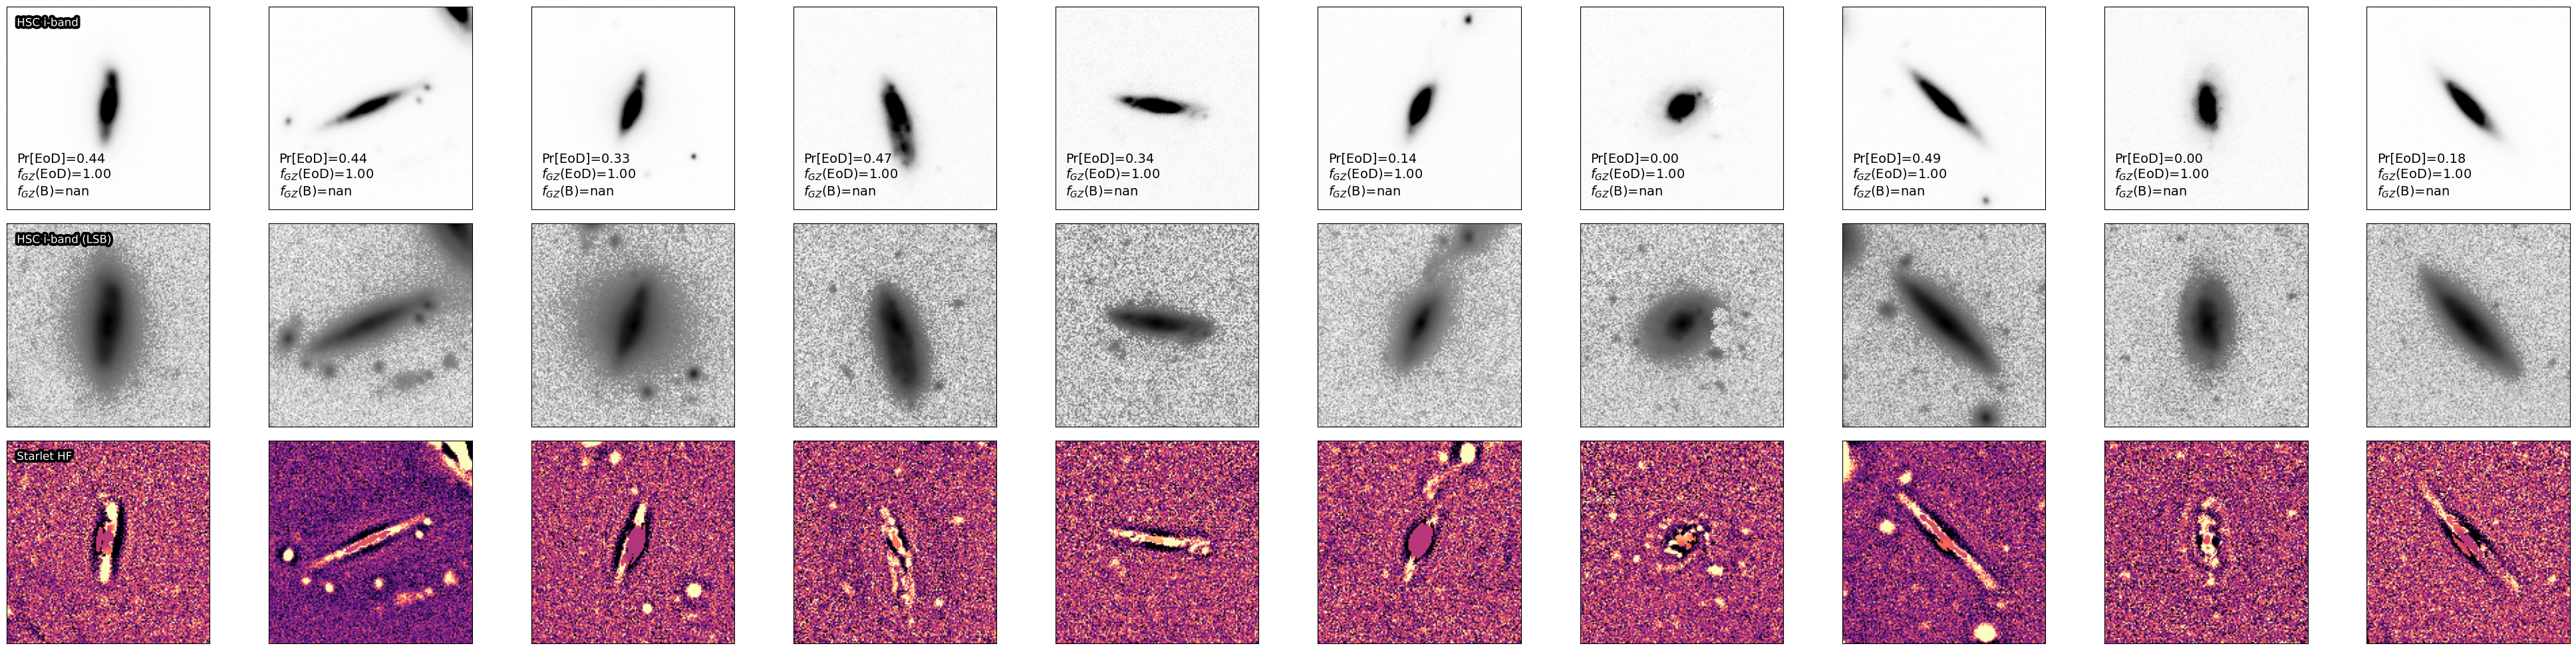

In [1017]:
# Show examples of merger candidates
candidates = np.arange(len(img_names))[has_classification][(prob_labels_iter[has_classification,2]<0.5)&(test_labels[has_classification]==2)]
n_examples = min(10, len(candidates))
np.random.seed(19)
if n_examples > 0:
    example_indices = np.random.choice(candidates, n_examples, replace=False)
    
    fig, axarr = plt.subplots(3, n_examples, figsize=(4*n_examples, 10))
    
    for idx, gix in enumerate(example_indices):
        # Load this specific image on-demand
        img_name = img_names[gix]
        image = load_image_by_name(img_name, data_path)
        
        # i-band
        ek.imshow(image[1], ax=axarr[0, idx], q=0.01, cmap='Greys')
        
        # i-band log scale
        axarr[1, idx].imshow(
            image[1],
            origin='lower',
            cmap='Greys',
            norm=colors.SymLogNorm(linthresh=0.1)
        )
        
        # High-frequency
        ek.imshow(image[2], ax=axarr[2, idx], cmap='magma')
        if img_name in gzmatch.index:
            ek.text(0.05, 0.05,
                    rf'''Pr[EoD]={prob_labels_iter[gix, 2]:.2f}
$f_{{GZ}}$(EoD)={gzmatch.loc[img_name,'DEOyes']:.2f}
$f_{{GZ}}$(B)={1.-gzmatch.loc[img_name,'BSNo']:.2f}''',
                    ax=axarr[0,idx])
        else:
            ek.text(0.05, 0.05,
                    rf'''Pr[EoD]={prob_labels_iter[gix, 2]:.2f}''',
                    ax=axarr[0,idx]) 
    
    for ax in axarr.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    
    ek.text(0.05, 0.95, 'HSC i-band', ax=axarr[0, 0], fontsize=12, 
            bordercolor='k', color='w', borderwidth=6)
    ek.text(0.05, 0.95, 'HSC i-band (LSB)', ax=axarr[1, 0], fontsize=12,
            bordercolor='k', color='w', borderwidth=6)
    ek.text(0.05, 0.95, 'Starlet HF', ax=axarr[2, 0], fontsize=12,
            bordercolor='k', color='w', borderwidth=6)
    
    plt.tight_layout()
    plt.show()
else:
    print("No merger candidates found")

In [655]:
from ekfstats import sampling

In [768]:
from ekfplot import legend

In [363]:

for img_name in tqdm(img_names):
    fig, axarr = plt.subplots(1,3,figsize=(12,4))
    
    image = load_image_by_name(img_name, data_path)
    ek.imshow(image[1], ax=axarr[0], q=0.01, cmap='Greys')

    # i-band log scale
    axarr[1].imshow(
        image[1],
        origin='lower',
        cmap='Greys',
        norm=colors.SymLogNorm(linthresh=0.1)
    )
    
    # High-frequency
    ek.imshow(image[2], ax=axarr[2], cmap='magma')    

    for ax in axarr:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout ()
    plt.savefig(f'/Users/kadofong/work/surveys/merian/quick_projects/vizinspect_eod/fig_source/massive_galaxies/{img_name}_i_starlet_qa.png')
    plt.close()

100%|███████████████████████████████████████| 3883/3883 [11:31<00:00,  5.62it/s]


In [694]:
sampling.bootstrap_histcounts(
    catalog.reindex(gzmatch.index).loc[:,'logmass_adjusted'],
    weights=catalog.reindex(gzmatch.index).loc[:,'p_eod'],
    **histkwargs
).shape

(1000, 11)

array([ 9.22963956, 10.38635304])

In [961]:
histkwargs = {'bins':np.linspace(*np.quantile(catalog.reindex(gzmatch.index).loc[:,'logmass_adjusted'],[0.025,0.975]),12)}

hasvotes = np.isfinite(catalog.reindex(gzmatch.index).loc[:,'logmass_adjusted'])&np.isfinite(gzmatch['DEOyes'])
fullgz_counts, _ = np.histogram(catalog.reindex(gzmatch.index).loc[hasvotes,'logmass_adjusted'], **histkwargs)
full_counts, _ = np.histogram(catalog.loc[:,'logmass_adjusted'], **histkwargs)

#matched = sampling.make_matched_sample(catalog.loc[:,'logmass_adjusted'], catalog.reindex(gzmatch.index).loc[:,'logmass_adjusted'])
pweighted_counts = sampling.bootstrap_histcounts(
    catalog.reindex(gzmatch.index).loc[:,'logmass_adjusted'],
    weights=catalog.reindex(gzmatch.index).loc[:,'p_eod'],
    **histkwargs
)
pweighted_fullcounts = sampling.bootstrap_histcounts(
    catalog.loc[:,'logmass_adjusted'],
    weights=catalog.loc[:,'p_eod'],
    **histkwargs
)

phc_counts = sampling.bootstrap_histcounts(
    catalog.loc[:,'logmass_adjusted'],
    weights=(catalog.loc[:,'p_eod'] > 0.5).astype(float),
    **histkwargs
)

gzvoted_counts = sampling.bootstrap_histcounts(
    catalog.reindex(gzmatch.index).loc[hasvotes,'logmass_adjusted'],
    weights=gzmatch.loc[hasvotes, 'DEOyes'],
    **histkwargs
)

hasvotes = np.isfinite(catalog.reindex(gzmatch.index).loc[:,'logmass_adjusted'])&np.isfinite(gzmatch['DEOyes'])&(gzmatch['DEOyes']>0.5)
gzhc_counts = sampling.bootstrap_histcounts(
    catalog.reindex(gzmatch.index).loc[hasvotes,'logmass_adjusted'],
    **histkwargs
)


In [962]:
def qplot(xs, color, ax=None, normalize=False, lw=1, ls='-', type='fill_between', **kwargs):    
    if ax is None:
        ax = plt.subplot(111)
        
    bmidpts = sampling.midpts(histkwargs['bins'])

    if normalize:
        nrml = lambda ys: ys/np.nanmedian(xs,axis=0).mean()
    else:
        nrml = lambda ys: np.where(np.nanmedian(xs,axis=0)==0, np.nan, ys)

    if type == 'fill_between':
        ax.plot(bmidpts, nrml(np.nanmedian(xs,axis=0)/fullgz_counts), color=color, lw=lw, ls=ls, **kwargs)
        ax.fill_between(
            bmidpts,
            nrml(np.nanquantile(xs,0.025, axis=0)/fullgz_counts),
            nrml(np.nanquantile(xs,0.985, axis=0)/fullgz_counts),
            alpha=0.1,
            color=color,
        )    
        ax.fill_between(
            bmidpts,
            nrml(np.nanquantile(xs,0.16, axis=0)/fullgz_counts),
            nrml(np.nanquantile(xs,0.84, axis=0)/fullgz_counts),
            alpha=0.3,
            color=color,
        )
    elif type=='errorbar':
        ek.errorbar(
            bmidpts,
            nrml(np.nanmedian(xs,axis=0)/fullgz_counts),
            ylow=nrml(np.nanquantile(xs,0.16, axis=0)/fullgz_counts),
            yhigh=nrml(np.nanquantile(xs,0.84, axis=0)/fullgz_counts),
            color=color,
            ax=ax,
            **kwargs
        )
    

In [964]:
from ekfplot import colorlists

In [965]:
gama = query.load_gamacatalogs()

In [966]:
gamaXgz, gzXgama = query.match_catalogs(gama.query("(Z>0.04)&(Z<0.12)"), gz_df.query('(z>0.04)&(z<0.12)'), coordkeysB=['RAdeg','DEdeg'])
gzXgama = gzXgama.reset_index().set_index(gamaXgz.index)

In [ ]:
gamaXgz.r_mag

In [1059]:
_, fd, ufd = sampling.classfraction(
    gamaXgz.loc[(gzXgama['DEOyes']>0.5)&(gzXgama['NbDEO']>1), 'r_mag'],
    gamaXgz.loc[(gzXgama['NbDEO']>2), 'r_mag'],
    bins=np.linspace(17., 19.,20),
)

<Axes: >

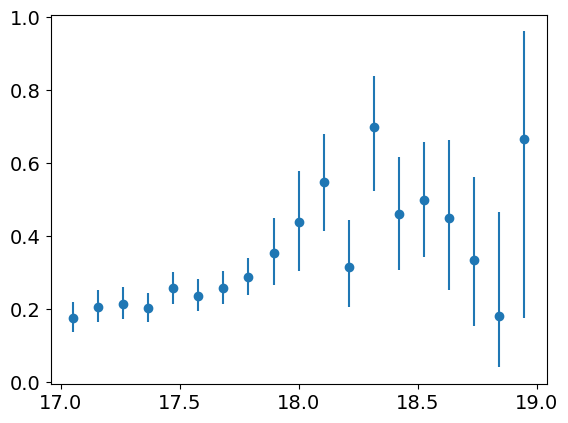

In [1060]:
ek.errorbar(
    sampling.midpts(np.linspace(17., 19.,20)),
    fd,
    ylow=ufd[0],
    yhigh=ufd[1]
)
    

In [968]:
out,_=query.match_catalogs(catalog, gz_df,coordkeysB=['RAdeg','DEdeg'])
out = out.reset_index().set_index(_.index)

In [982]:
x = sampling.bootstrap_histcounts(
    catalog.reindex(gzmatch.index).loc[hasvotes & (gzmatch['DEOyes'] > 0.5), 'logmass_adjusted'],
    bins=histkwargs['bins'],
)

In [986]:
np.median(x, axis=0)

array([ 3.,  5.,  8.,  6.,  7.,  4.,  6., 14.,  7.,  6.,  6.])

In [989]:
c,_=np.histogram(
    catalog.reindex(gzmatch.index).loc[hasvotes, 'logmass_adjusted'],
    bins=histkwargs['bins'],
)

In [991]:
np.median(x/c,axis=0)

array([0.1875    , 0.16666667, 0.26666667, 0.20689655, 0.17073171,
       0.08695652, 0.11538462, 0.31818182, 0.17073171, 0.15789474,
       0.23076923])

(0.0, 0.02)

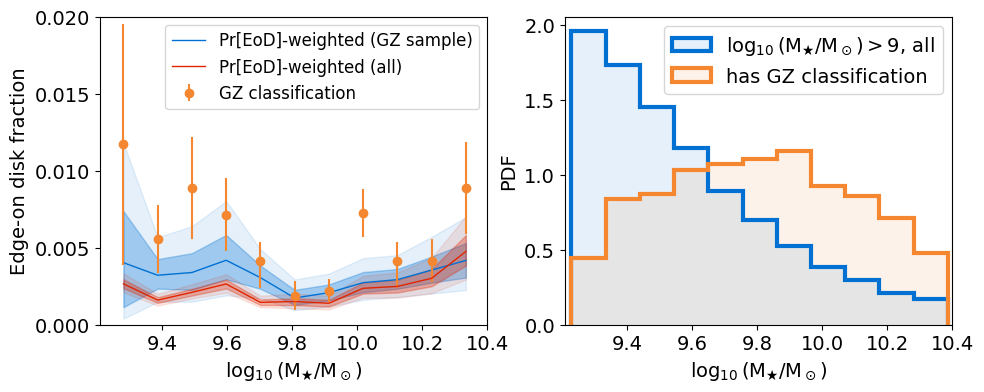

In [974]:
fig, axarr = plt.subplots(1,2,figsize=(11,4), sharex=True)
#qplot(phc_counts/fullgz_counts, 'C3',  ax=axarr[0], label='Pr[EoD] binary classification')
qplot(pweighted_counts/fullgz_counts, color=colorlists.slides['blue'], ax=axarr[0], label='Pr[EoD]-weighted (GZ sample)')
#qplot(gzvoted_counts/fullgz_counts, 'C1',  ax=axarr[0],label='GZ votes-weighted')
qplot(gzhc_counts/fullgz_counts, colorlists.slides['orange'], ax=axarr[0], label='GZ classification', type='errorbar')

qplot(pweighted_fullcounts/full_counts, colorlists.slides['red'], label='Pr[EoD]-weighted (all)', ls='-', ax=axarr[0])

#axarr[0].set_yscale('symlog', linthresh=1e-5)
axarr[0].legend(fontsize=12)
axarr[0].set_ylim(0., 0.01)
#ek.reshuffle_legend(axarr[0], [1,0,2,3], fontsize=11)

bins = histkwargs['bins']
ek.hist(
    catalog.loc[:,'logmass_adjusted'],
    bins=bins,
    density=True,
    ax=axarr[1],
    alpha=0.1,
    lw=3,
    color=colorlists.slides['blue'],
    label=r'$\log_{10}(\rm M_\bigstar/M_\odot)>9$, all'
)
ek.hist(
    catalog.reindex(gzmatch.index).loc[:,'logmass_adjusted'],
    bins=bins,
    density=True,
    ax=axarr[1],
    alpha=0.1,
    lw=3,
    color=colorlists.slides['orange'],
    label=r'has GZ classification'    
)

for ax in axarr:
    ax.set_xlabel(ek.common_labels['logmstar'])
    ax.set_xlim(9.21,10.4)
axarr[0].set_ylabel('Edge-on disk fraction')
axarr[1].set_ylabel("PDF")
axarr[1].legend()
axarr[0].set_ylim(0., 0.02)

In [881]:
cd ../figure_generation/

/Users/kadofong/work/projects/merian/pieridae/merger_analysis/figure_generation


In [882]:
import fg_galaxyzoo

In [883]:
logger = fg_galaxyzoo.setup_logging('INFO')

In [884]:
data = fg_galaxyzoo.load_data(config, logger)

2025-10-30 12:17:25,223 - fg_galaxyzoo - INFO - ============================================================
2025-10-30 12:17:25,224 - fg_galaxyzoo - INFO - LOADING DATA
2025-10-30 12:17:25,225 - fg_galaxyzoo - INFO - ============================================================
2025-10-30 12:17:25,225 - fg_galaxyzoo - INFO - Input path: ../../local_data/pieridae_output/starlet/massive_galaxies
2025-10-30 12:17:25,225 - fg_galaxyzoo - INFO - Output path: ../output/galaxy_zoo
2025-10-30 12:17:25,226 - fg_galaxyzoo - INFO - Loading image names...
2025-10-30 12:17:25,841 - fg_galaxyzoo - INFO - Found 3883 images
2025-10-30 12:17:25,842 - fg_galaxyzoo - INFO - Loading embeddings...
2025-10-30 12:17:25,845 - fg_galaxyzoo - INFO - Embeddings shape: (3883, 512)
2025-10-30 12:17:25,846 - fg_galaxyzoo - INFO - Computing PCA...
2025-10-30 12:17:25,846 - INFO - Computing PCA...
2025-10-30 12:17:25,925 - INFO - PCA components: 10
2025-10-30 12:17:25,926 - INFO - Explained variance: 86.6%
2025-10-30

Computed aperture correction in 0.0 seconds.
Computed line contamination correction in 0.0 seconds.
Loading precomputed Galactic extinction map...
Interpolated Galactic extinction values from map.
Computed Galactic extinction correction in 0.5 seconds.
Computed internal extinction corrections in 0.6 seconds.


/Users/kadofong/work/projects/merian/agrias/python/agrias/photometry.py:115: RuntimeWarning: invalid value encountered in log10
  lsq_y = np.log10(np.array([ fdict[band] for band in plawbands ]))
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
2025-10-30 12:17:27,716 - fg_galaxyzoo - INFO - Loading adjusted masses from individual files...
Loading masses:   0%|                                 | 0/54859 [00:00<?, ?it/s]/Users/kadofong/work/projects/merian/pieridae/merger_analysis/figure_generation/fg_galaxyzoo.py:251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [1055]:
fg_galaxyzoo.make_figure_galaxyzoo(
    data, 
    Path('./punchline_figures/'),
    logger
)


2025-10-30 14:56:17,328 - fg_galaxyzoo - INFO - Generating Galaxy Zoo EoD analysis figure
2025-10-30 14:56:17,330 - fg_galaxyzoo - INFO - Computing bootstrap histograms...
2025-10-30 14:56:17,938 - fg_galaxyzoo - INFO - Creating figure...
2025-10-30 14:56:17,952 - fg_galaxyzoo - INFO - Loading example images...
2025-10-30 14:56:18,427 - fg_galaxyzoo - INFO - Saved: punchline_figures/fg_galaxyzoo.pdf
